In [19]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import time
from tensorflow import keras

for module in (tf, mpl, np, pd, keras):
    print(module.__name__, module.__version__)

tensorflow 2.0.0-alpha0
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
tensorflow.python.keras.api._v2.keras 2.2.4-tf


## Load play datasets

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


## Normalize inputdata by using Sklearn Standscalar

- made x = (x - u) / std

In [10]:
from sklearn.preprocessing import StandardScaler

# before normalization
print(np.max(x_train), np.min(x_train))

# perform normalization
scaler = StandardScaler()
# 1. data in x_train is int32, we need to convert them to float32 first 
# 2. convert x_train data from 
#    [None, 28, 28] -> [None, 784] 
#       -> after all reshape back to [None, 28, 28]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled  = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

# after normalization
print(np.max(x_train_scaled), np.min(x_train_scaled))

255 0
2.0231433 -0.8105136


## Build model by using tf.keras high level API

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

# if y is one_hot vector then use categorical_crossentropy as loss function
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

## Train model with callback

In [36]:
# Tensorboard, EarlyStopping, ModelCheckPoint
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks

logdir = './callbacks' # logdir for tensorboard logdata
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")    

callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-3)
]

history = model.fit(x = x_train_scaled, y = y_train, epochs = 10, 
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks = callbacks)

# once training is finished, you can use tensorboard to visualize results
# tensorboard --logdir=callbacks

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3864 - accuracy: 0.8626 - val_loss: 0.3866 - val_accuracy: 0.8626
Epoch 2/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3798 - accuracy: 0.8661 - val_loss: 0.3862 - val_accuracy: 0.8660
Epoch 3/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3739 - accuracy: 0.8669 - val_loss: 0.3776 - val_accuracy: 0.8672
Epoch 4/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.3679 - accuracy: 0.8697 - val_loss: 0.3750 - val_accuracy: 0.8684
Epoch 5/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.3627 - accuracy: 0.8706 - val_loss: 0.3719 - val_accuracy: 0.8676
Epoch 6/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3578 - accuracy: 0.8735 - val_loss: 0.3681 - val_accuracy: 0.8732
Epoch 7/10
55000/55000 [==============================] -

## Result visualization

<built-in method keys of dict object at 0x7f39fd6a98b8>


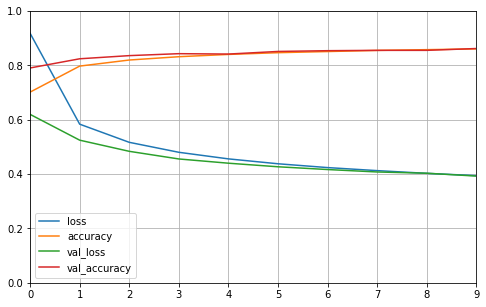

In [24]:
from tensorflow.python.keras.callbacks import History

def plot_learning_curves(history: History):
    pd.DataFrame(history.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

## Evaluate model with test dataset

In [33]:
test_loss, test_acc = model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 0s 47us/sample - loss: 0.4323 - accuracy: 0.8436


## Made a simple prediction on test dataset

In [37]:
# one_hot encoded results
predictions = model.predict(x_test)
print(predictions[0])

# compare ml-prediction to test label
print(np.argmax(predictions[0]), y_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9 9
